# Project 2: Wind Simulator Design
>**Date Created**: 10 February 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [453]:
import numpy as np
import scipy as sp
import sympy as smp

from matplotlib import pyplot as plt
from scipy import stats
from numpy.linalg import norm
plt.rcParams['text.usetex'] = True

In [550]:
v_infinity = 824 # ft/ sec
alt = 20000 # ft
dt = 0.01 # sec
mu = 0 # ft/s

### a) Implement a dsicretized version of the continuous-time Dryden gust model at $\Delta t$ = $0.01$ s.

In [551]:
def calc_A(v_inf, alt, sigma_u, sigma_v, sigma_w):
    h = alt
    u = v_inf
    if h >= 1750:
        Lu, Lv, Lw = 1750, 1750, 1750
    else:
        Lu = h
        Lv = 145*h**(1/3)
        Lw = 145*h**(1/3)
    mat = np.array([[-norm(u)/Lu, 0, 0, 0, 0],
                   [0, -norm(u)/Lv, sigma_v*(1-np.sqrt(3))*(norm(u)/Lv)**(3/2), 0, 0],
                   [0, 0, -norm(u)/Lv, 0, 0],
                   [0, 0, 0, -norm(u)/Lw, sigma_w*(1-np.sqrt(3))*(norm(u)/Lw)**(3/2)],
                   [0, 0, 0, 0, -norm(u)/Lw]])

    return mat

In [552]:
def calc_B(v_inf, alt, sigma_u, sigma_v, sigma_w):
    h = alt
    u = v_inf
    if h >= 1750:
        Lu, Lv, Lw = 1750, 1750, 1750
    else:
        Lu = h
        Lv = 145*h**(1/3)
        Lw = 145*h**(1/3)
    mat = np.array([sigma_u*np.sqrt((2*norm(u)/(np.pi*Lu))),sigma_v*np.sqrt((3*norm(u)/(Lv))), 1, sigma_w*np.sqrt((3*norm(u)/(Lw))), 1])
    return mat

In [553]:
def simulate_dryden(v_inf, alt, sigma_u, sigma_v, sigma_w, tstart, tend, dt):
    # Define constants for simulation
    nsteps = int((tend-tstart)/dt)
    t_eval = np.linspace(tstart, tfinal, nsteps)
    results = np.zeros((5, nsteps))
    
    # Calculate dynamics matrices and generate multivariate normal distribution with variance 1/dt
    A, B = calc_A(v_inf, alt, sigma_u, sigma_v,sigma_w), calc_B(v_inf, alt, sigma_u, sigma_v,sigma_w)
    P = np.array([[np.sqrt(1/dt), 0, 0, 0, 0], 
                [0, np.sqrt(1/dt), 0, 0, 0],
                [0,0, np.sqrt(1/dt),0, 0],
                [0,0,0, np.sqrt(1/dt), 0],
                [0,0,0, 0, np.sqrt(1/dt)]])
    n_t = stats.multivariate_normal([0,0,0,0,0], cov=P)
    n_i = n_t.rvs(size=nsteps).T
    
    # Discretize dynamics and simulate gust model
    Ad = sp.linalg.expm(A*dt)
    Bd = np.linalg.inv(A) @ (Ad - np.eye(5)) @ B
    for k, t in enumerate(t_eval):
        if k == 0:
            x = np.array([0,0,0,0,0])
            results[:,k] = x
            continue
        xkp1 = Ad @ x + Bd * n_i[:,k]
        results[:,k] = xkp1
        x = xkp1
    return t_eval, results
    
    

### b) Simulate the Dryden gust model for 600 seconds for three cases:
1. Light:  $\sigma_u$ = $\sigma_v$ = $\sigma_w$ = 5 ft/sec 
1. Moderate:  $\sigma_u$ = $\sigma_v$ = $\sigma_w$ = 10 ft/sec
1. Severe:  $\sigma_u$ = $\sigma_v$ = $\sigma_w$ = 20 ft/sec 

In [566]:
# Case 1 - Light Gusts
sigma_u_light, sigma_v_light, sigma_w_light = 5, 5, 5
t, results_case1 = simulate_dryden(v_infinity, alt, sigma_u_light, sigma_v_light, sigma_w_light,0, 600, dt)

In [567]:
# Case 2 - Moderate Gusts
sigma_u_moderate, sigma_v_moderate, sigma_w_moderate = 10, 10, 10
t, results_case2 = simulate_dryden(v_infinity, alt, sigma_u_moderate, sigma_v_moderate, sigma_w_moderate,0, 600, dt)

In [568]:
# Case 3 - Severe Gusts
sigma_u_severe, sigma_v_severe, sigma_w_severe = 20, 20, 20
t, results_case3 = simulate_dryden(v_infinity, alt, sigma_u_severe, sigma_v_severe, sigma_w_severe,0, 600, dt)

### c) Generate three plots of the gust components, one for each gust component, $u_g$, $v_g$, and $w_g$ with all three simulation data sets for a gust component on the same plot

In [569]:
def plot_gust_component(t, light_data, moderate_data, severe_data, label='w_g',save=False):
    myDict = dict(zip(['u_g', 'v_g', 'w_g'], [0, 1, 3]))
    idx = myDict[label]
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=((15,10)), dpi = 400)
    ax.plot(t, severe_data[idx,:], label = r'Case 3 - Severe Gusts, $\sigma_g = 20 \frac{ft}{s}$')
    ax.plot(t, moderate_data[idx,:], label = r'Case 2 - Moderate Gusts, $\sigma_g = 10 \frac{ft}{s}$')
    ax.plot(t, light_data[idx,:], label = r'Case 1 - Light Gusts, $\sigma_g = 5 \frac{ft}{s}$')
    ax.set_xlabel('Time, $s$', fontsize=18)
    ax.set_ylabel('Gust Velocity, $ft/s$',fontsize=18)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(f'${label}$',fontsize=25)
    ax.set_ylim([-40, 40])
    ax.set_xlim([0, 600])
    ax.grid()
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,1,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=15,edgecolor='black',fancybox=False)
    plt.show()
    if save:
        fig.savefig(f'{label}.png')

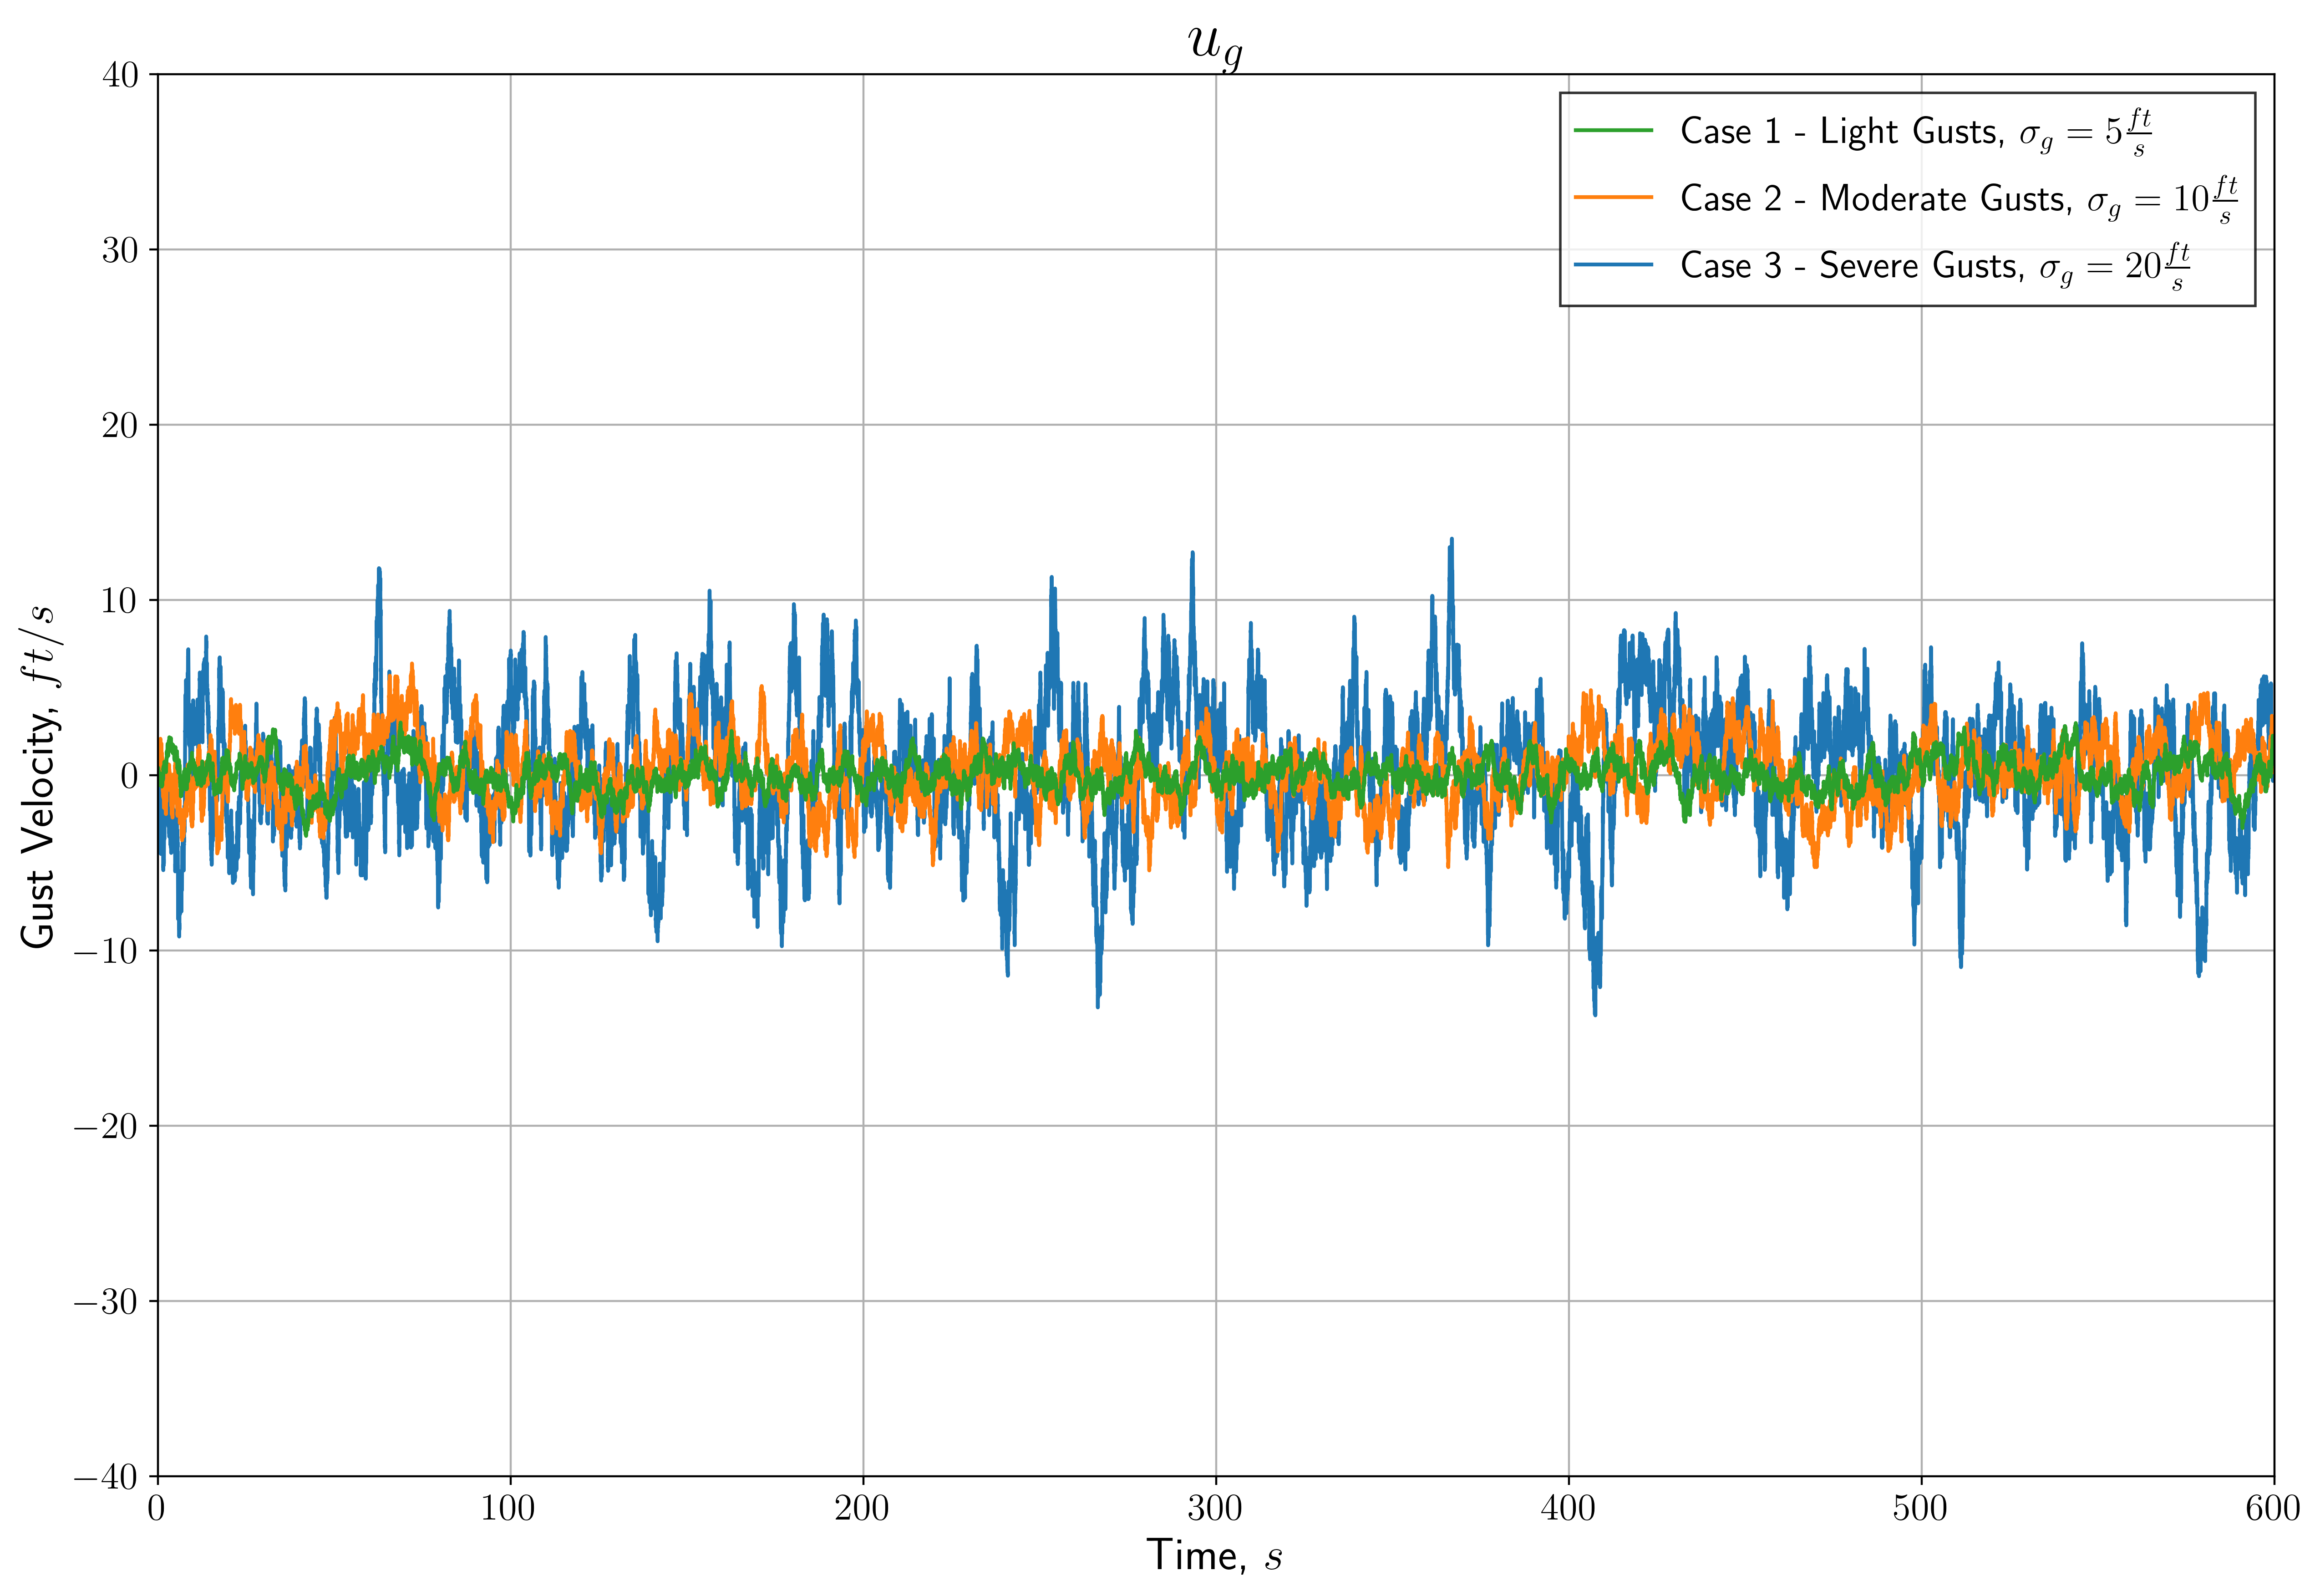

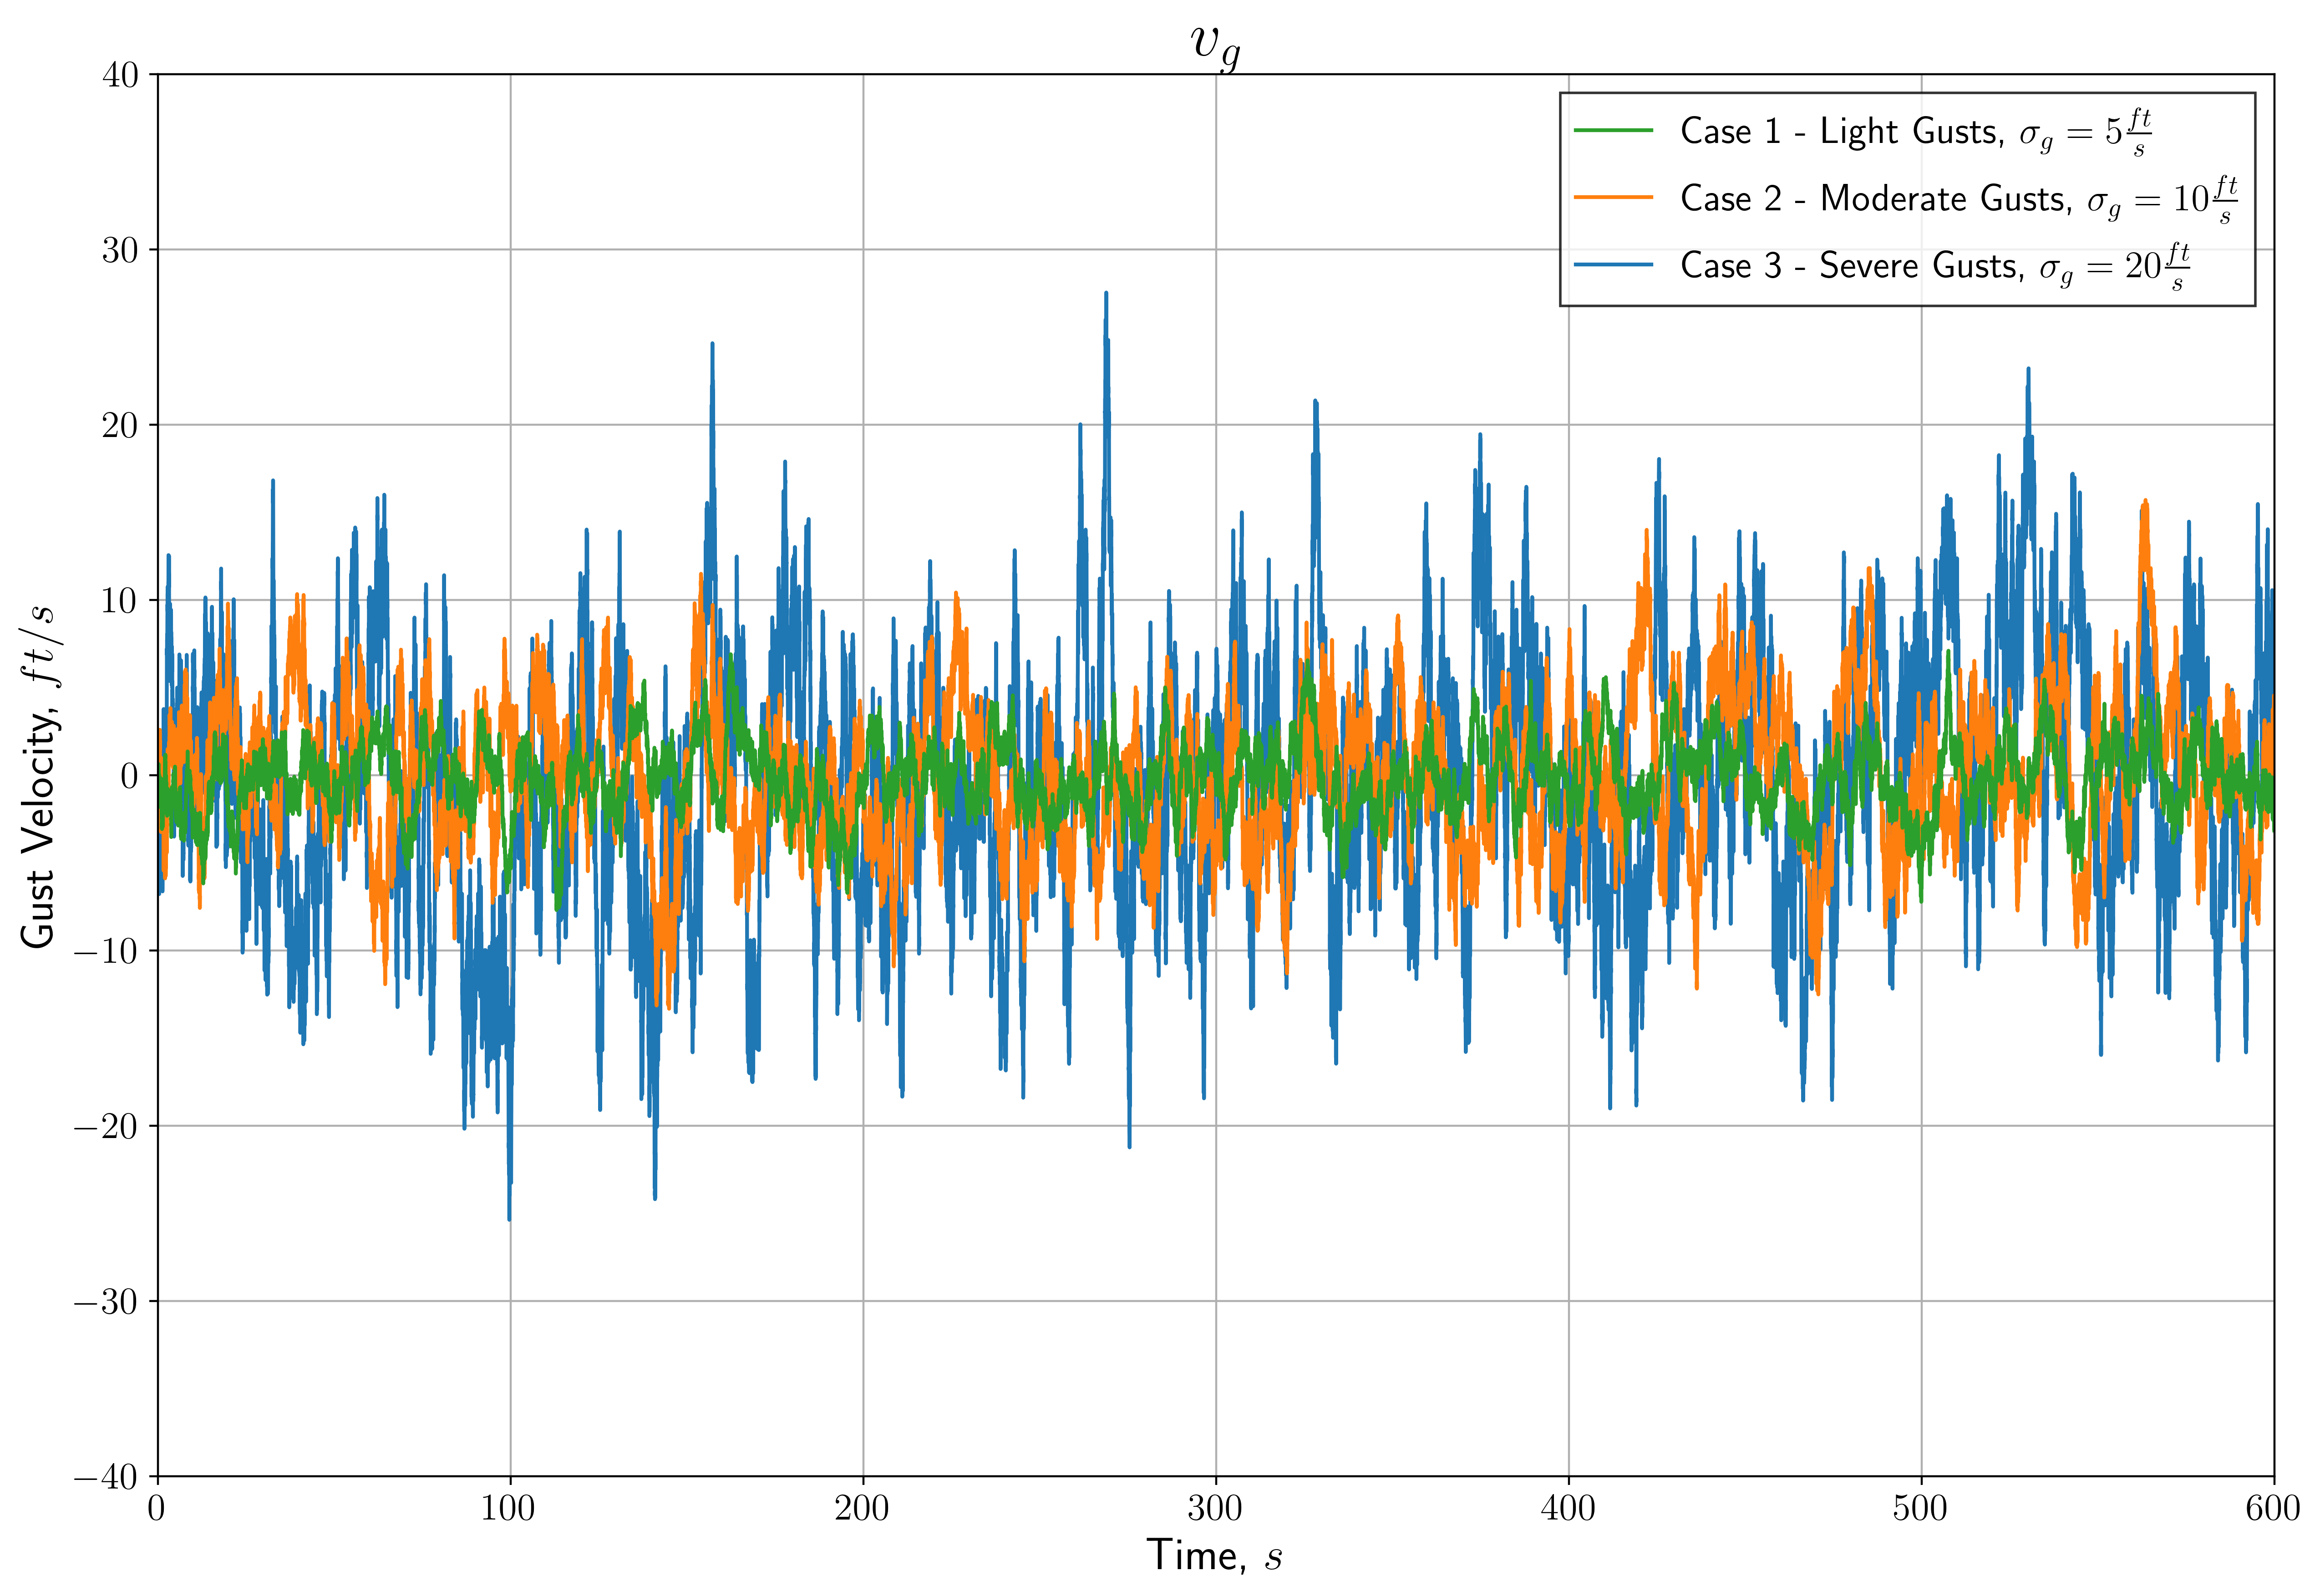

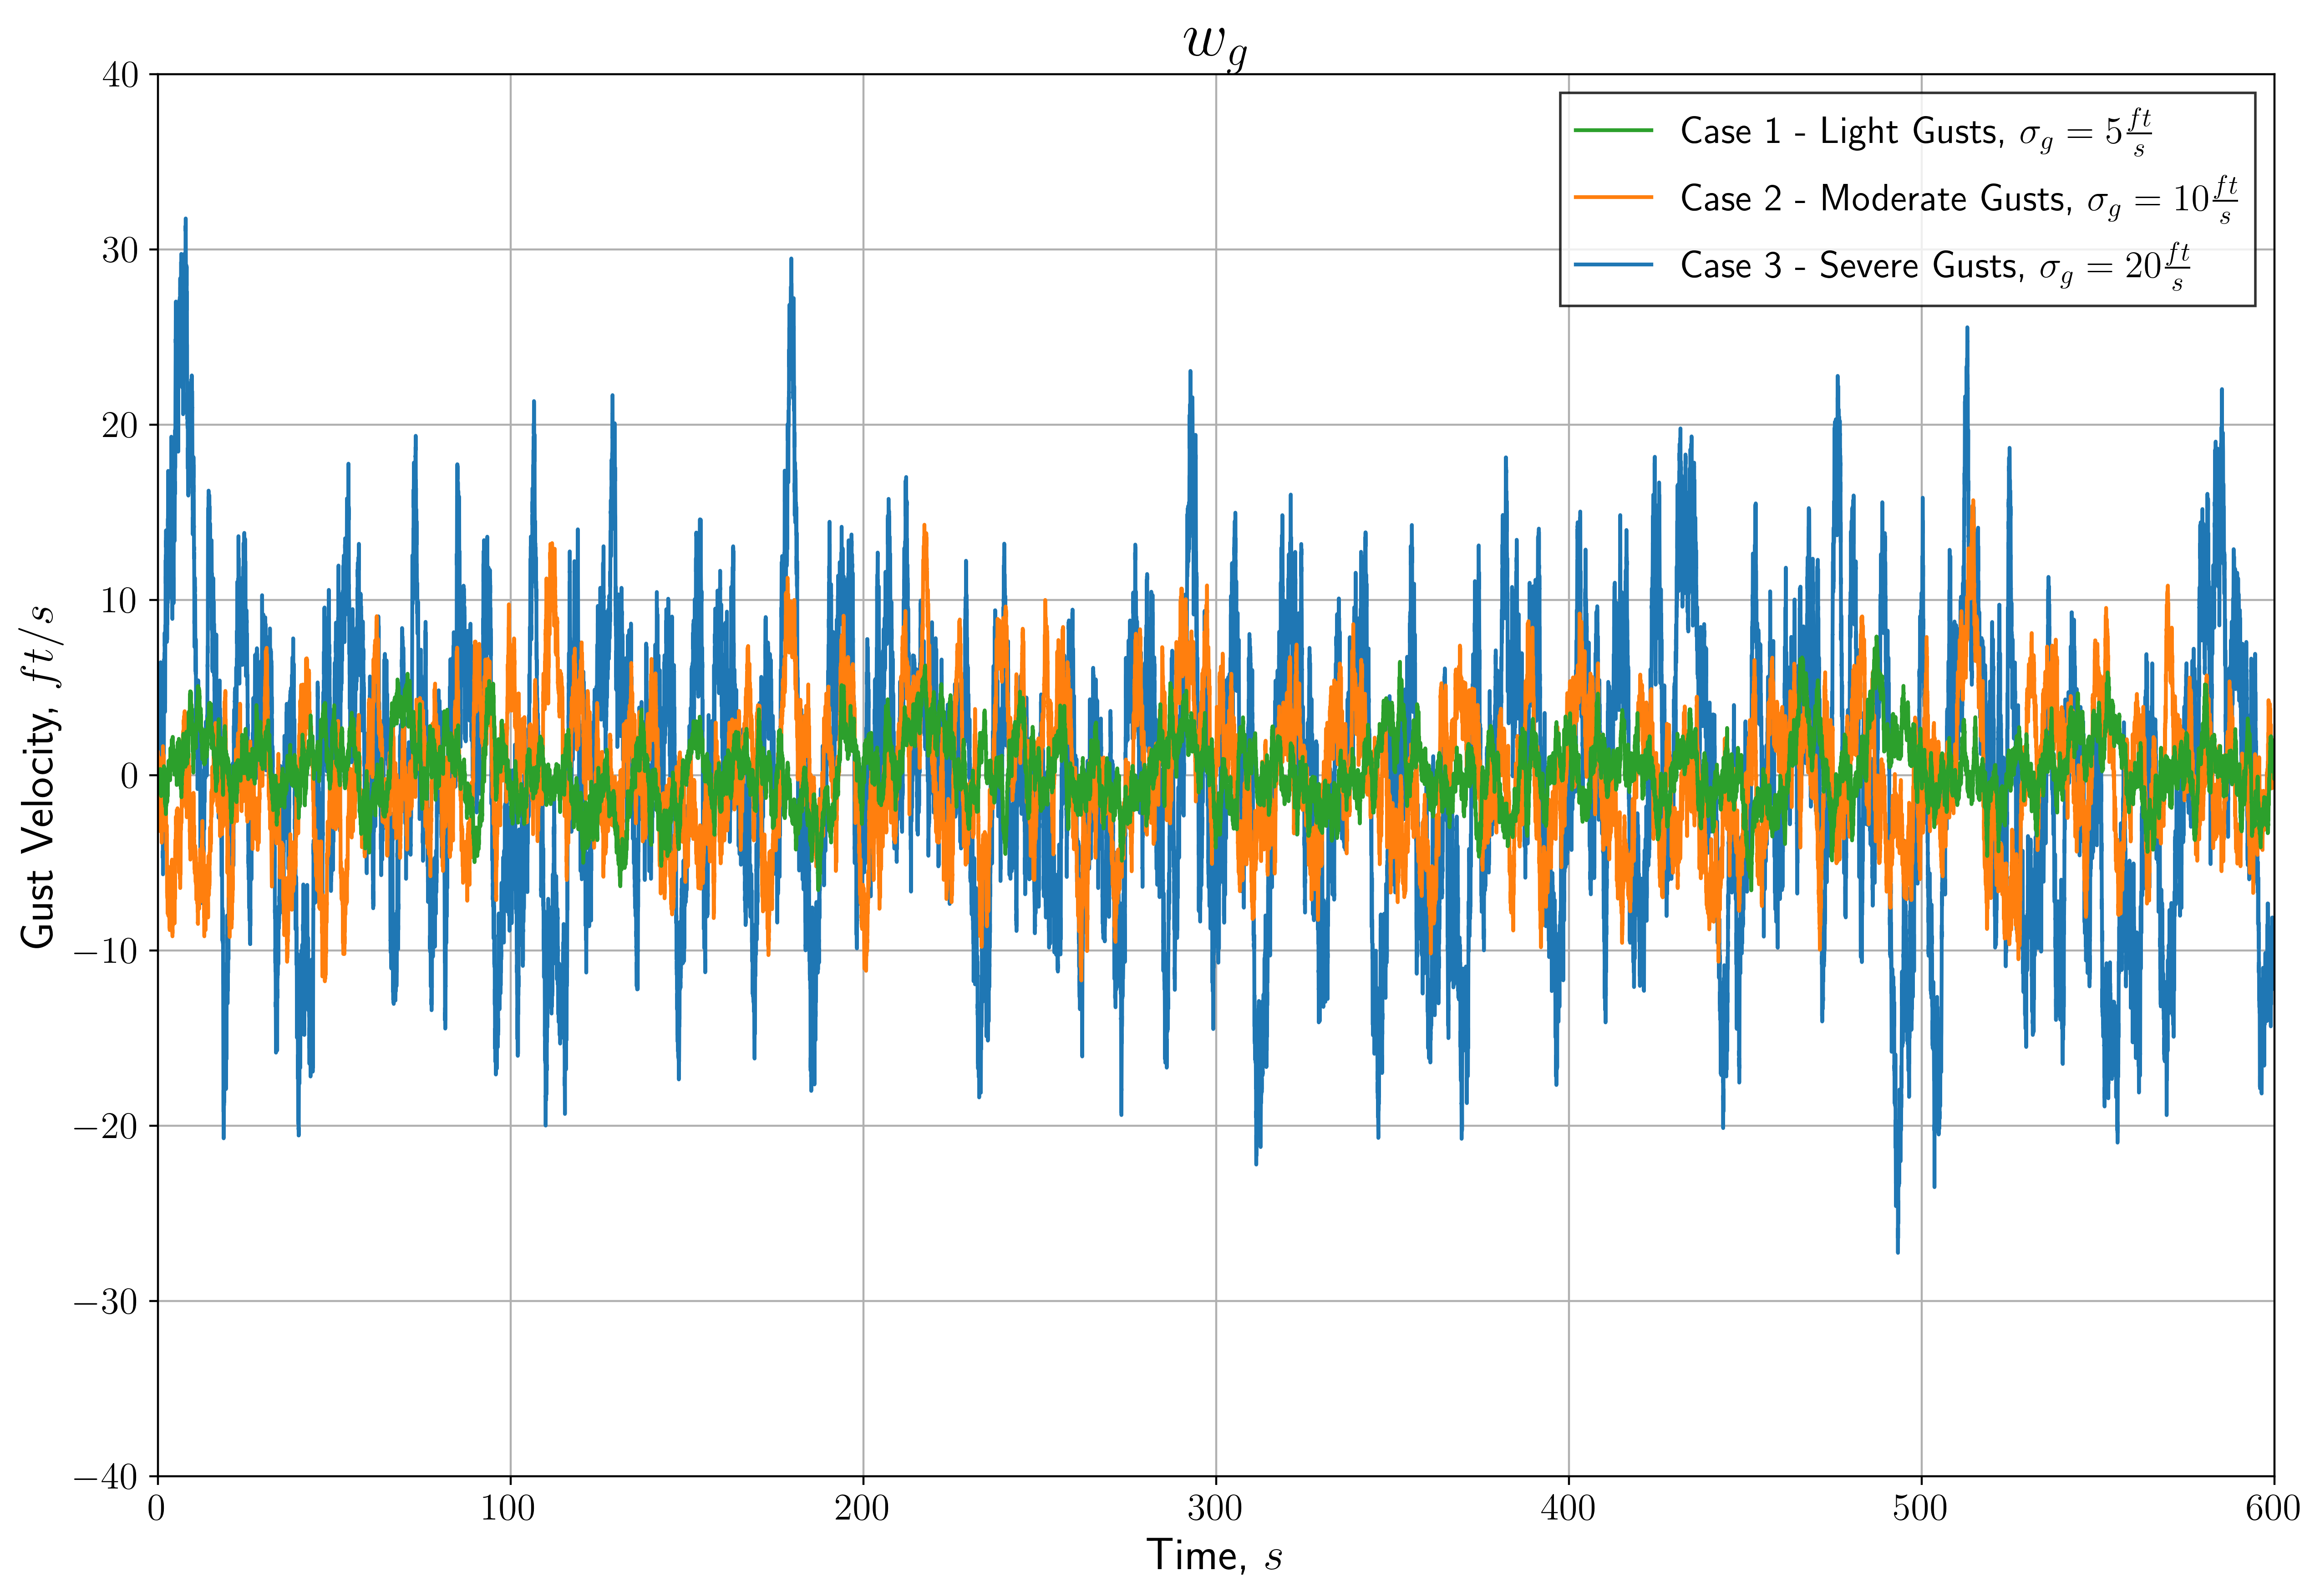

In [570]:
plot_gust_component(t, results_case1, results_case2, results_case3, 'u_g')
plot_gust_component(t, results_case1, results_case2, results_case3, 'v_g')
plot_gust_component(t, results_case1, results_case2, results_case3, 'w_g')

### d) Comment on the differences between the light, moderate, and severe gust simulations for the gusts over the 10 minutes of simulation

- The maginitude of the gusts along $u_g$ direction remain much smaller than that of the other directions due to the singular dependence on the damping provided by the characteristic length and the norm of the velocity vector. 
- Along the $v_g$ and $w_g$ direcitons, the magnitudes of the gusts reach higher values due to second order 'memory' terms in the A matrix and dependence on the value of $\sigma$ for that particular component.